In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [4]:
def illum_data():
    """
    Reproduce the MATLAB ‘illum_data’ routine.

    Returns
    -------
    L : (2, m) ndarray
        Lamp coordinates.
    V : (2, n+1) ndarray
        End‑points of the surface patches.
    A : (n, m) ndarray
        Illumination matrix: row k is a_k^T.
    """
    # Lamp locations ---------------------------------------------------------
    L = np.vstack(
        (
            np.linspace(0.0, 1.0, 10),
            np.array([1.9, 1.8, 1.0, 1.1, 1.9, 1.8, 1.9, 1.7, 1.5, 1.5]),
        )
    )
    m = L.shape[1]

    # Patch vertices ----------------------------------------------------------
    V = np.vstack(
        (
            np.linspace(0.0, 1.0, 21),
            0.4
            * np.array(
                [
                    0.0,
                    0.1,
                    0.15,
                    0.2,
                    0.1,
                    0.2,
                    0.3,
                    0.0,
                    0.0,
                    0.0,
                    0.1,
                    0.2,
                    0.2,
                    0.0,
                    0.1,
                    0.05,
                    0.1,
                    0.1,
                    0.0,
                    0.2,
                    0.1,
                ]
            ),
        )
    )
    n = V.shape[1] - 1  # number of patches

    # Quick visual check ------------------------------------------------------
    plt.figure(1)
    plt.plot(L[0], L[1], "o", label="lamps")
    plt.plot(V[0], V[1], "-", label="patch polyline")
    plt.axis("equal")
    plt.legend()

    # Geometry helpers --------------------------------------------------------
    dV = V[:, 1 : n + 1] - V[:, :n]  # patch tangents
    VI = V[:, :n] + 0.5 * dV  # patch mid‑points

    A = np.zeros((n, m))
    for i in range(n):
        # Unit normal pointing “upwards”
        t = dV[:, i]
        n_perp = np.array([-t[1], t[0]])  # 90° CCW rotation
        if n_perp[1] < 0:
            n_perp = -n_perp  # flip so y‑component ≥ 0
        n_perp_norm = np.linalg.norm(n_perp)

        for j in range(m):
            dVI = L[:, j] - VI[:, i]
            dist = np.linalg.norm(dVI)
            cosine = dVI.dot(n_perp) / (dist * n_perp_norm)
            A[i, j] = max(0.0, cosine) / dist**2

    return L, V, A

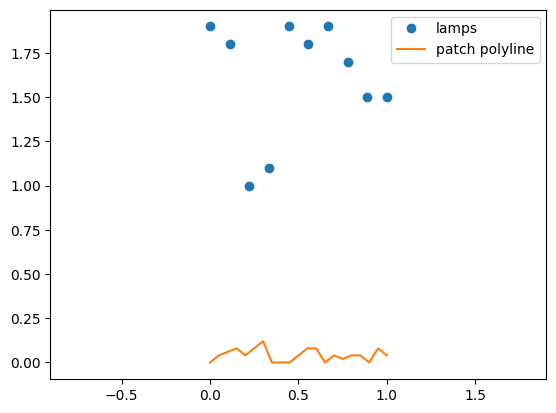

In [5]:
L, V, A = illum_data()

In [22]:
# m = lamps, n = patches
m = 10
n = 20


def f0(p):
    return np.max(np.abs(np.log(A @ p)))

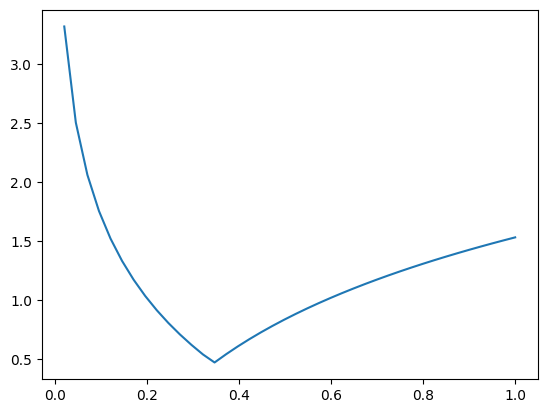

In [23]:
fig, ax = plt.subplots()

gamma = np.linspace(0.02, 1, 40)
output = [f0(g * np.ones(m)) for g in gamma]

ax.plot(gamma, output)
plt.show()

Minimum is f0(p) ~ 0.5 at gamma = ~3.2?


**Least squares**


In [49]:
p = cp.Variable(m)
obj = cp.Minimize(cp.norm(A @ p - np.ones(n)))

prob = cp.Problem(obj)
prob.solve()

pstar = np.clip(p.value, 0, 1)
pstar, f0(pstar)

(array([1., 0., 1., 0., 0., 1., 0., 1., 0., 1.]),
 np.float64(0.8627835587119419))

**Regularized least squares**


In [56]:
rho = 0
while True:
    rho += 0.01
    p = cp.Variable(m)
    obj = cp.Minimize(cp.norm(A @ p - np.ones(n)) + rho * cp.norm(p - 0.5 * np.ones(m)))

    prob = cp.Problem(obj)
    prob.solve()

    if (0 <= p.value).all() and (p.value <= 1).all():
        break

prob.status, prob.value, rho, p.value, f0(p.value)

('optimal',
 np.float64(1.0278643450527405),
 0.16,
 array([0.49981962, 0.47714549, 0.08322163, 0.0010934 , 0.45579852,
        0.4352384 , 0.45948655, 0.43061222, 0.40346457, 0.45251405]),
 np.float64(0.44397419593181))

**Chebyshev**


In [58]:
p = cp.Variable(m)
obj = cp.Minimize(cp.norm(A @ p - np.ones(n), "inf"))
cons = [0 <= p, p <= 1]

prob = cp.Problem(obj, cons)
prob.solve()
prob.status, prob.value, np.round(p.value, 4), f0(p.value)

('optimal',
 np.float64(0.34283766130811744),
 array([1.    , 0.1165, 0.    , 0.    , 1.    , 0.    , 1.    , 0.0249,
        0.    , 1.    ]),
 np.float64(0.4198242001642196))

**Exact solution**


In [59]:
p = cp.Variable(m)
obj = cp.Minimize(cp.max(cp.maximum(A @ p, cp.inv_pos(A @ p))))
cons = [0 <= p, p <= 1]

prob = cp.Problem(obj, cons)
prob.solve()
prob.status, prob.value, np.round(p.value, 4), f0(p.value)

('optimal',
 1.4297138566685141,
 array([1.    , 0.2023, 0.    , 0.    , 1.    , 0.    , 1.    , 0.1882,
        0.    , 1.    ]),
 np.float64(0.3574743240172851))

Solution checks out.
